In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [225]:
### 2-D SPH Toy Model
ZERO = np.array([0., 0., 0.])
DENS = 600
MASS = 0.21
GRAV = np.array([0., -9.8, 0.])
KSTIFF = .3
PFAC = 7.0
THRESHOLDSQR = 7
SURFTENS = 0.05
VISC = .03

In [226]:
class Particle:
    def __init__(self, loc= np.array([0., 0., 0.]), vel= np.array([0., 0., 0.])):
        self.loc = loc
        self.vel = vel
        self.acc =  np.array([0., 0., 0.])
        self.force =  np.array([0., 0., 0.])
        
        self.before_vel, self.after_vel =  np.array([0., 0., 0.]),  np.array([0., 0., 0.])
        
        self.neighbors = []
        self.dens = DENS
        self.mass = MASS
        self.pressure = 101325
        
    def move(self, tstep):
        pass

In [227]:
def wpoly6(r,h):
    coeff = 315/(64*np.pi*h**9)
    mag = np.sqrt(np.dot(r,r))
    if mag > h:
        return 0.0
    
    return coeff * (h**2 - mag**2)**3

def dpoly6(r,h):
    coeff = -945/(32*np.pi*h**9)
    mag = np.sqrt(np.dot(r,r))
    if mag > h:
        return np.array([0., 0., 0.])
    
    return coeff * r * (h**2 - mag**2)**2

def ddpoly6(r, h):
    rmagsq = np.dot(r,r)
    hsqr = h*h
    coeff = -945/(32*np.pi*h**9)
    if rmagsq <= hsqr:
        return coeff * (hsqr - rmagsq)*(3*hsqr - 7*rmagsq)
    else:
        return 0.0
    
def viscoKernel(r, h):
    rmag = np.sqrt(np.dot(r,r))
    coeff = 45/(np.pi*h**6)
    if rmag <=h:
        return (h-rmag)*coeff
    else:
        return 0.0
    
def densityKernel(r,h):
    rmagsq = np.dot(r,r)
    hsqr = h**2
    coeff = 315/(64*np.pi*h**9)
    if rmagsq <= hsqr:
        return coeff * (hsqr-rmagsq)**3
    else:
        return 0.0
    
def pressureKernel(r,h):
    coeff = -45/(np.pi*h**6)
    rmag = np.sqrt(np.dot(r,r))
    if rmag <= h:
        return r * coeff * (h-rmag)**2 * (1.0/rmag)
    else:
        return np.array([0., 0., 0.])

In [245]:
class SPH:
    BOXWIDTH = 3.0
    TSTEP = 0.003
    def __init__(self, num_part=529, num_steps=1000, H=0.15):
        self.RIGHTWALL = 1
        self.H = H
        self.N = num_part
        self.particles = []#np.array([Particle() for i in range(num_part)])
        self.num_steps = num_steps
        for i in range(220):
            x = random.uniform(0,1)
            y = random.uniform(0,2.5)
            self.particles.append(Particle(np.array([x,y,0.])))
        self.spaces = {}
    
    def find_neighbors(self):
        self.spaces = {}
        for i,p in enumerate(self.particles):
            x = int(np.floor(p.loc[0]/self.H))
            y = int(np.floor(p.loc[1]/self.H))
            key = str(x)+'x,' + str(y)
            self.spaces[key] = self.spaces.get(key, []) + [i]
            p.neighbors = []
            
        for i,p in enumerate(self.particles):
            x = int(np.floor(p.loc[0]/self.H))
            y = int(np.floor(p.loc[1]/self.H))
            key = str(x)+'x,' + str(y)
            p.neighbors = [n for n in self.spaces[key] if n != i]
            
            neighboring_cells = [str(x+1)+'x,' + str(y-1),str(x+1)+'x,' + str(y),str(x+1)+'x,' + str(y+1),
                                str(x)+'x,' + str(y+1),str(x)+'x,' + str(y-1),
                                str(x-1)+'x,' + str(y-1),str(x-1)+'x,' + str(y),str(x-1)+'x,' + str(y+1)]
            for ky in neighboring_cells:
                p.neighbors += self.spaces.get(ky, [])
    
    
    def calc_density_pressure(self):
        for i,p in enumerate(self.particles):
            density, pressure = 0.,0.
            for j in p.neighbors:
                r_ = p.loc - self.particles[j].loc
                density += self.particles[j].mass*densityKernel(r_, self.H)
            density += p.mass*densityKernel(0, self.H)
            p.dens = density
            #p.pressure = KSTIFF * ((density/DENS)**PFAC - 1)
            p.pressure = KSTIFF *(p.dens - DENS)
    
    def calc_forces(self):
        for i,p in enumerate(self.particles):
            pressure_force = np.array([0.,0., 0.])
            visco_force = np.array([0.,0., 0.])
            surface_force = np.array([0.,0., 0.])
            surface_forcedn = 0.
            for j in p.neighbors:
                p2 = self.particles[j]
                r_ = p.loc - p2.loc
                pressure_force -= (p.dens + p2.dens)/(p.dens**2 + p.dens**2)*pressureKernel(r_,self.H)
                visco_force += VISC*(p2.vel - p.vel) * p2.mass/p2.dens * viscoKernel(r_, self.H)
                surface_force += (p2.mass/p2.dens) * dpoly6(r_, self.H)
                surface_forcedn += ddpoly6(r_, self.H) * p2.mass/p2.dens
                
            
            surface1 = np.sqrt(np.dot(surface_force,surface_force))
            if surface1 >= THRESHOLDSQR:
                surface_force = surface_force * SURFTENS * (-surface_forcedn/np.sqrt(surface1))
            else:
                surface_foce = 0
            p.force = p.mass*GRAV + pressure_force + visco_force + surface_force
            p.acc = (1/p.mass)*p.force
    
    def integrate(self):
        for i,p in enumerate(self.particles):
            p.after_vel = p.before_vel + SPH.TSTEP*p.acc
            p.vel = 0.5 * (p.before_vel + p.after_vel)
            p.before_vel = p.after_vel
            p.loc += p.after_vel*SPH.TSTEP
            
            if p.loc[1] <= 0:
                if p.after_vel[1] < 0:
                    p.after_vel[1] *= -0.8
                    p.after_vel[0] *= 0.8
                p.vel = p.after_vel;
                p.before_vel = p.after_vel
                p.loc[1] = -p.loc[1]
            ''' 
            if p.loc[1] >= SPH.BOXWIDTH:
                if p.after_vel[1] > 0:
                    p.after_vel[1] *= -0.8
                    p.after_vel[0] *= 0.8
                p.vel = p.after_vel;
                p.before_vel = p.after_vel
                p.loc[1] = 0.95*SPH.BOXWIDTH
             '''   
            if p.loc[0] <= 0:
                if p.after_vel[0] < 0:
                    p.after_vel[0] *= -0.8
                    p.after_vel[1] *= 0.8
                p.vel = p.after_vel;
                p.before_vel = p.after_vel
                p.loc[0] = -p.loc[0]
                
            if p.loc[0] >= self.RIGHTWALL:
                if p.after_vel[0] > 0:
                    p.after_vel[0] *= -0.8
                    p.after_vel[1] *= 0.8
                p.vel = p.after_vel;
                p.before_vel = p.after_vel
                p.loc[0] =self.RIGHTWALL - (p.loc[0] - self.RIGHTWALL)
            
    def simulate(self):
        self.find_neighbors()
        self.calc_density_pressure()
        self.calc_forces()
        self.integrate()
        
    def plot_frame(self):
        X = np.array([p.loc[0] for p in self.particles])
        Y = np.array([p.loc[1] for p in self.particles])
        
        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(X, Y, 'o')
        ax.set_xlim(0, SPH.BOXWIDTH)
        ax.set_ylim(0, SPH.BOXWIDTH)
        
    def get_xy(self):
        X = np.array([p.loc[0] for p in self.particles])
        Y = np.array([p.loc[1] for p in self.particles])
        return X, Y

In [246]:
s = SPH()

In [247]:
s.find_neighbors()
s.calc_density_pressure()
s.calc_forces()

In [248]:
s.simulate()

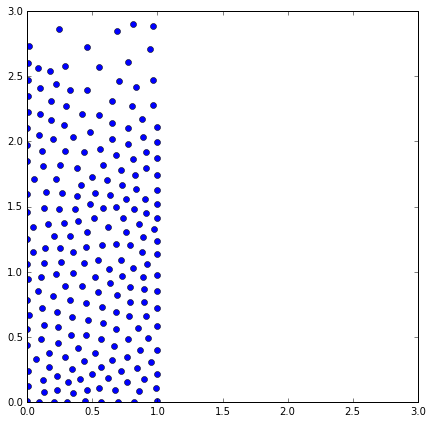

In [253]:
for t in range(10):
    s.simulate()
s.plot_frame()

In [125]:
s.particles[5].loc, s.particles[25].dens

(array([ 0.26584316,  0.24797367,  0.        ]), 220.1403911334188)

In [124]:
s.particles[115].dens

98.489942384254491

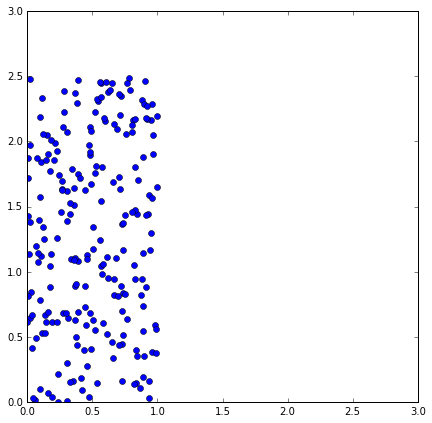

In [249]:
s.plot_frame()

In [356]:
np.sqrt(np.dot(r_, r_))

0.68181818181818177

13.818413659884547

In [103]:
from matplotlib import animation

In [254]:
SIM = SPH()

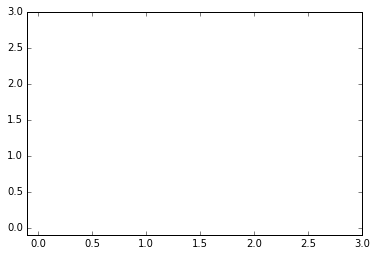

In [255]:
fig, ax = plt.subplots()
ax.set_xlim(-0.1, SPH.BOXWIDTH)
ax.set_ylim(-0.1, SPH.BOXWIDTH)
line, = ax.plot([],[], 'bo')
tm = 0
def init():
    line.set_data([],[])
    return line,

def animate(i):
    SIM.simulate()
    if i % 100 == 0:
        print(i)
    if i == 500:
        SIM.RIGHTWALL = 3
    #tm += 0.001
    X,Y = SIM.get_xy()
    line.set_data(X,Y)
    return line,

In [241]:
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=1500, interval=100, blit=True)

In [ ]:
begin = datetime.datetime.now()
anim.save('sph_2017-st.mp4', fps=50, extra_args=['-vcodec', 'libx264'])
end = datetime.datetime.now()

0


In [26]:
%timeit SIM.simulate()

1 loops, best of 3: 2.55 s per loop


In [244]:
(end - begin)

datetime.timedelta(0, 306, 572962)

In [235]:
end

datetime.datetime(2017, 6, 16, 16, 37, 32, 594345)

In [236]:
begin

datetime.datetime(2017, 6, 16, 16, 34, 47, 235052)

In [237]:
165/60

2.75